# ENSO composites for MERRA-2/SIRS model
## HCoV-HKU1 parameters
## year of ENSO event (year 0), +1, +2

Created Feb 16 2024

Last modified Aug 20 2024

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#define figure resolution
plt.rcParams['figure.dpi'] = 250

In [2]:
# specify the time resolution of the MERRA-2 data that was used to force the SIRS model
res = 'weekly' # 'daily', 'weekly_spinup21'

In [3]:
HKU1 = xr.open_dataset(f'./data_{res}/HKU1_monthly_mean.nc') # monthly mean data
clim = xr.open_dataset(f'./data_{res}/HKU1_clim_month.nc') # climatology
anom = xr.open_dataset(f'./data_{res}/HKU1_anom_month.nc') # anomaly from climatology

In [4]:
# import the ENSO years data
df=pd.read_csv('./ENSO_yrs_final.csv', index_col=0)
df

ds = df.to_xarray().astype(bool)
ds

<xarray.Dataset>
Dimensions:    (year: 37)
Coordinates:
  * year       (year) int64 1981 1982 1983 1984 1985 ... 2014 2015 2016 2017
Data variables:
    ElNino     (year) bool False True False False ... True True False False
    LaNina     (year) bool False False True True False ... False False True True
    Neutral    (year) bool True False False False ... False False False False
    ElNino_1   (year) bool False False True False ... False True True False
    LaNina_1   (year) bool False False False True ... False False False True
    Neutral_1  (year) bool True True False False ... True False False False
    ElNino_2   (year) bool True False False True False ... False False True True
    LaNina_2   (year) bool False False False False ... False False False False
    Neutral_2  (year) bool False True True False False ... True True False False

### Put HKU1 data into years and months format (instead of straight timeseries)

In [15]:
allyrs = np.unique(HKU1.TIME.dt.year)

In [16]:
from tqdm.notebook import tqdm

for ii in tqdm(range(allyrs.size)):
    # get data from that year
    data_monthly = HKU1.isel(TIME=slice(ii*12,ii*12+12))
    #print(data_temp)

    data_monthly = data_monthly.rename({'TIME': 'month'})
    data_monthly['month'] = np.arange(1, 13)

    data_monthly = data_monthly.assign_coords(year=allyrs[ii])

    if ii == 0:
        HKU1_yearmonth = data_monthly
    else:
        HKU1_yearmonth = xr.concat([HKU1_yearmonth,data_monthly], dim='year')

  0%|          | 0/37 [00:00<?, ?it/s]

In [18]:
HKU1_yearmonth

<xarray.Dataset>
Dimensions:  (LAT: 361, LON: 576, month: 12, year: 37)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * LAT      (LAT) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * LON      (LON) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * year     (year) int64 1981 1982 1983 1984 1985 ... 2013 2014 2015 2016 2017
Data variables:
    IT       (year, month, LAT, LON) float32 0.005549 0.005549 ... 0.006142
    ST       (year, month, LAT, LON) float32 0.4111 0.4111 ... 0.5909 0.5909
    R0       (year, month, LAT, LON) float32 2.403 2.403 2.403 ... 2.338 2.338

In [20]:
HKU1_yearmonth.to_netcdf(f"./data_{res}/HKU1_yearmonth.nc")

# ENSO composites 
## El Nino, La Nina, neutral, +1 year, +2 years

In [21]:
comp_types = list(ds.data_vars)
print(comp_types)

['ElNino', 'LaNina', 'Neutral', 'ElNino_1', 'LaNina_1', 'Neutral_1', 'ElNino_2', 'LaNina_2', 'Neutral_2']


In [23]:
for ii in tqdm(range(np.size(comp_types))):

    composite_type = comp_types[ii]
    
    # get event years
    event_years = ds.year[ds[composite_type]]

    # get years from data.TIME
    years_array = pd.DatetimeIndex(HKU1.TIME).year

    # for each year in the list, find the events_all from that year
    included_bool_array = [year in event_years for year in years_array]

    # get all the events from the data
    events_all = HKU1.isel(TIME=included_bool_array)
    
    # put into year/month format
    for ii in range(event_years.size):
        # get data from that year
        data_monthly = events_all.isel(TIME=slice(ii*12,ii*12+12))
        #print(data_temp)

        data_monthly = data_monthly.rename({'TIME': 'month'})
        data_monthly['month'] = np.arange(1, 13)

        data_monthly = data_monthly.assign_coords(year=event_years[ii])

        if ii == 0:
            events_yearmonth = data_monthly
        else:
            events_yearmonth = xr.concat([events_yearmonth,data_monthly], dim='year')

    # compute composite
    comp = events_yearmonth.mean('year')

    events_yearmonth.to_netcdf(f"./data_{res}/ENSO_HKU1_{composite_type}_allevents.nc")
    comp.to_netcdf(f"./data_{res}/ENSO_HKU1_{composite_type}_composite.nc")


  0%|          | 0/9 [00:00<?, ?it/s]

# Plot El Niño minus La Niña composite

In [6]:
# load data
EN_mean = xr.open_dataset(f"./data_{res}/ENSO_HKU1_ElNino_composite.nc")
LN_mean = xr.open_dataset(f"./data_{res}/ENSO_HKU1_LaNina_composite.nc")
N_mean = xr.open_dataset(f"./data_{res}/ENSO_HKU1_Neutral_composite.nc")

EN_1_mean = xr.open_dataset(f"./data_{res}/ENSO_HKU1_ElNino_1_composite.nc")
LN_1_mean = xr.open_dataset(f"./data_{res}/ENSO_HKU1_LaNina_1_composite.nc")
N_1_mean = xr.open_dataset(f"./data_{res}/ENSO_HKU1_Neutral_1_composite.nc")

EN_2_mean = xr.open_dataset(f"./data_{res}/ENSO_HKU1_ElNino_2_composite.nc")
LN_2_mean = xr.open_dataset(f"./data_{res}/ENSO_HKU1_LaNina_2_composite.nc")
N_2_mean = xr.open_dataset(f"./data_{res}/ENSO_HKU1_Neutral_2_composite.nc")


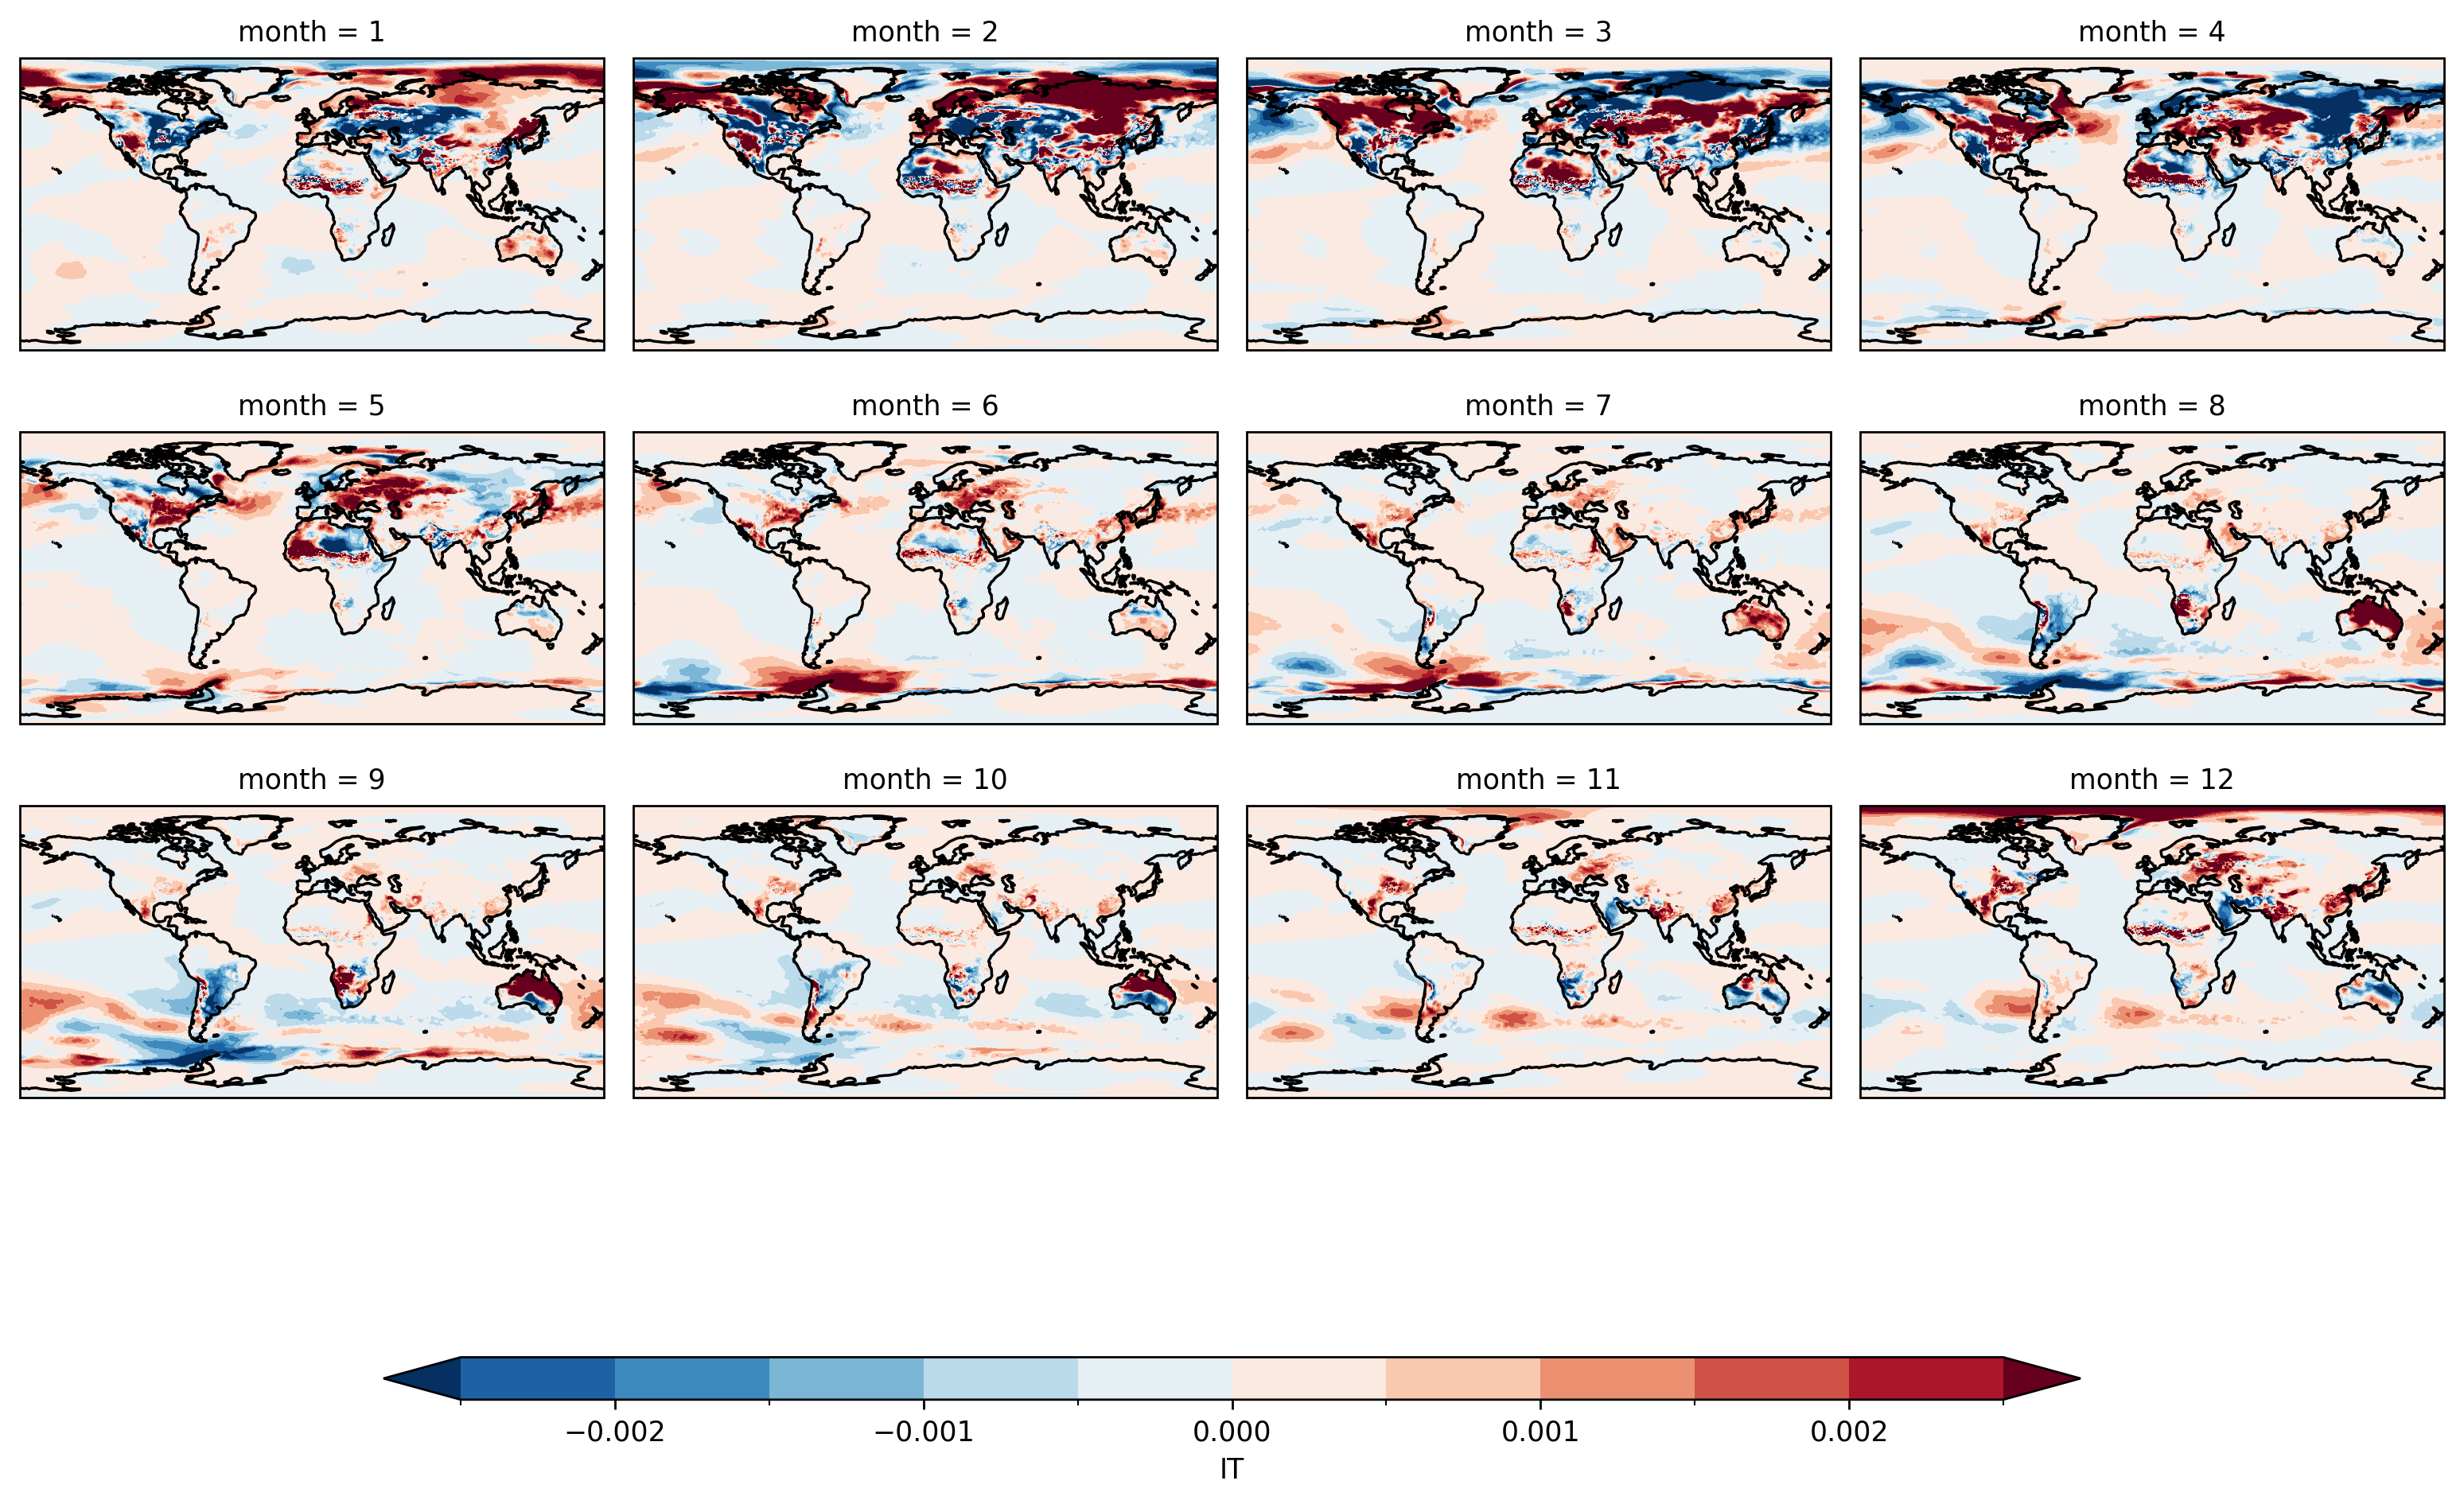

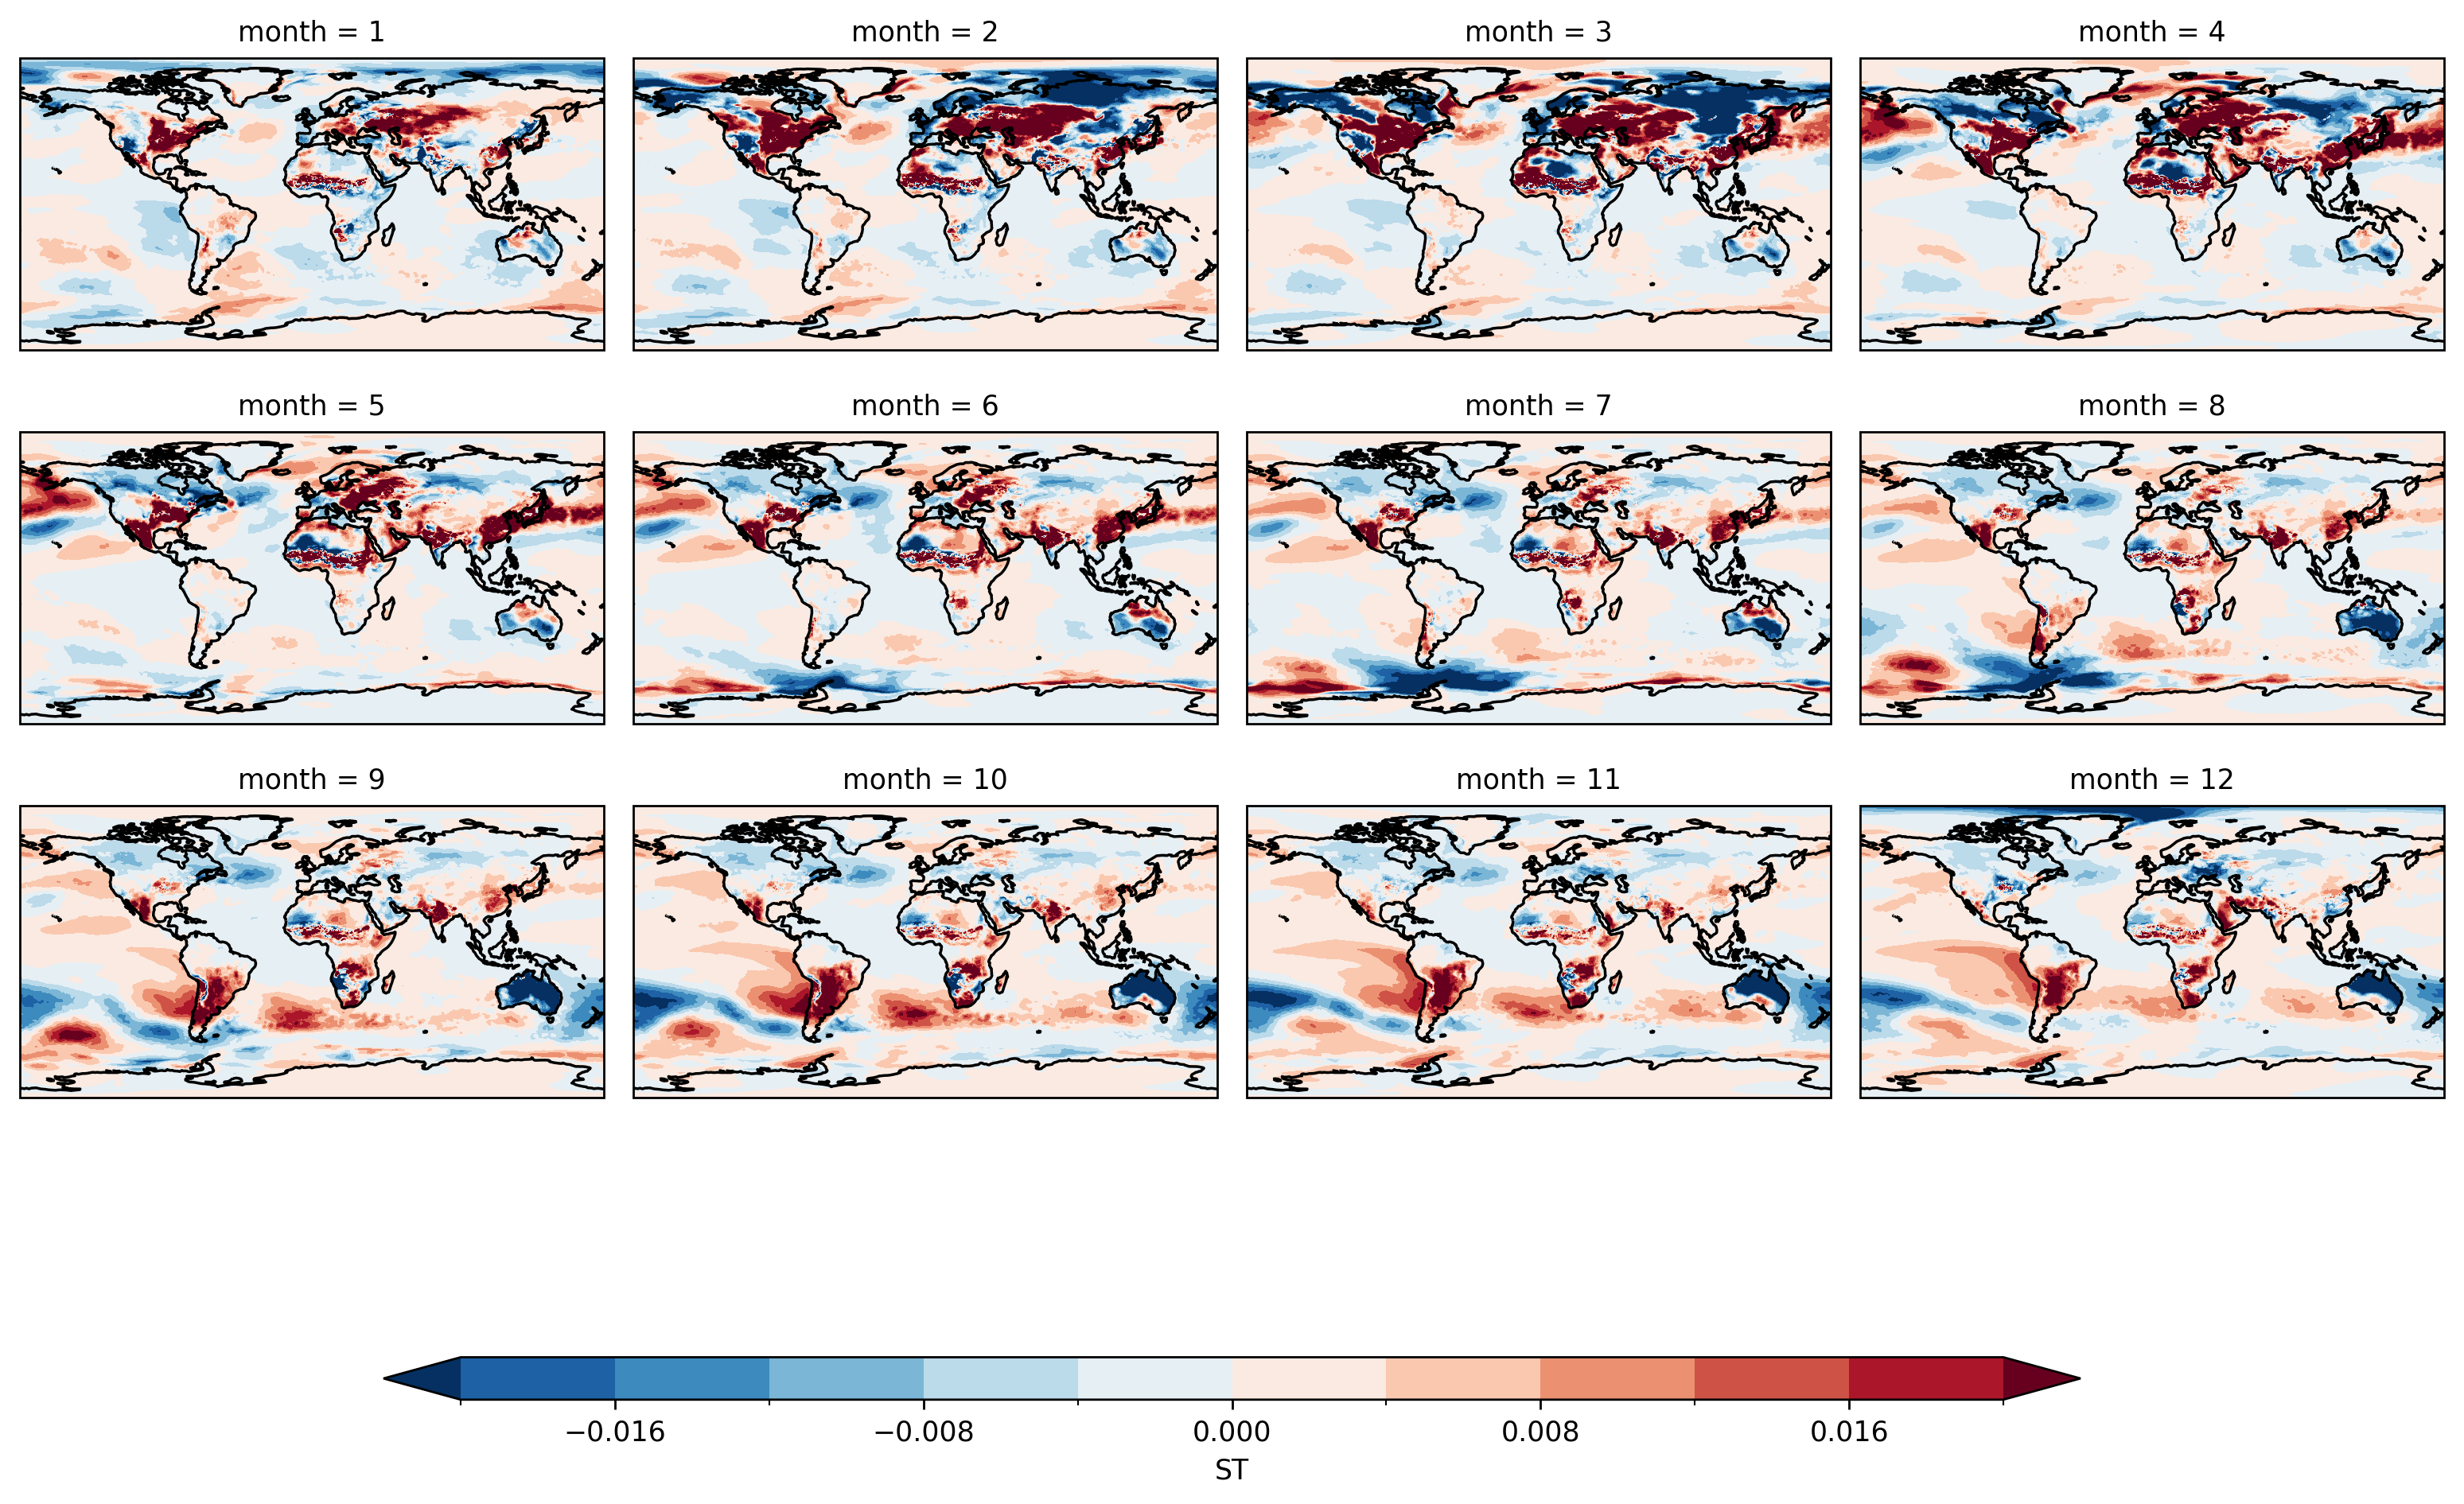

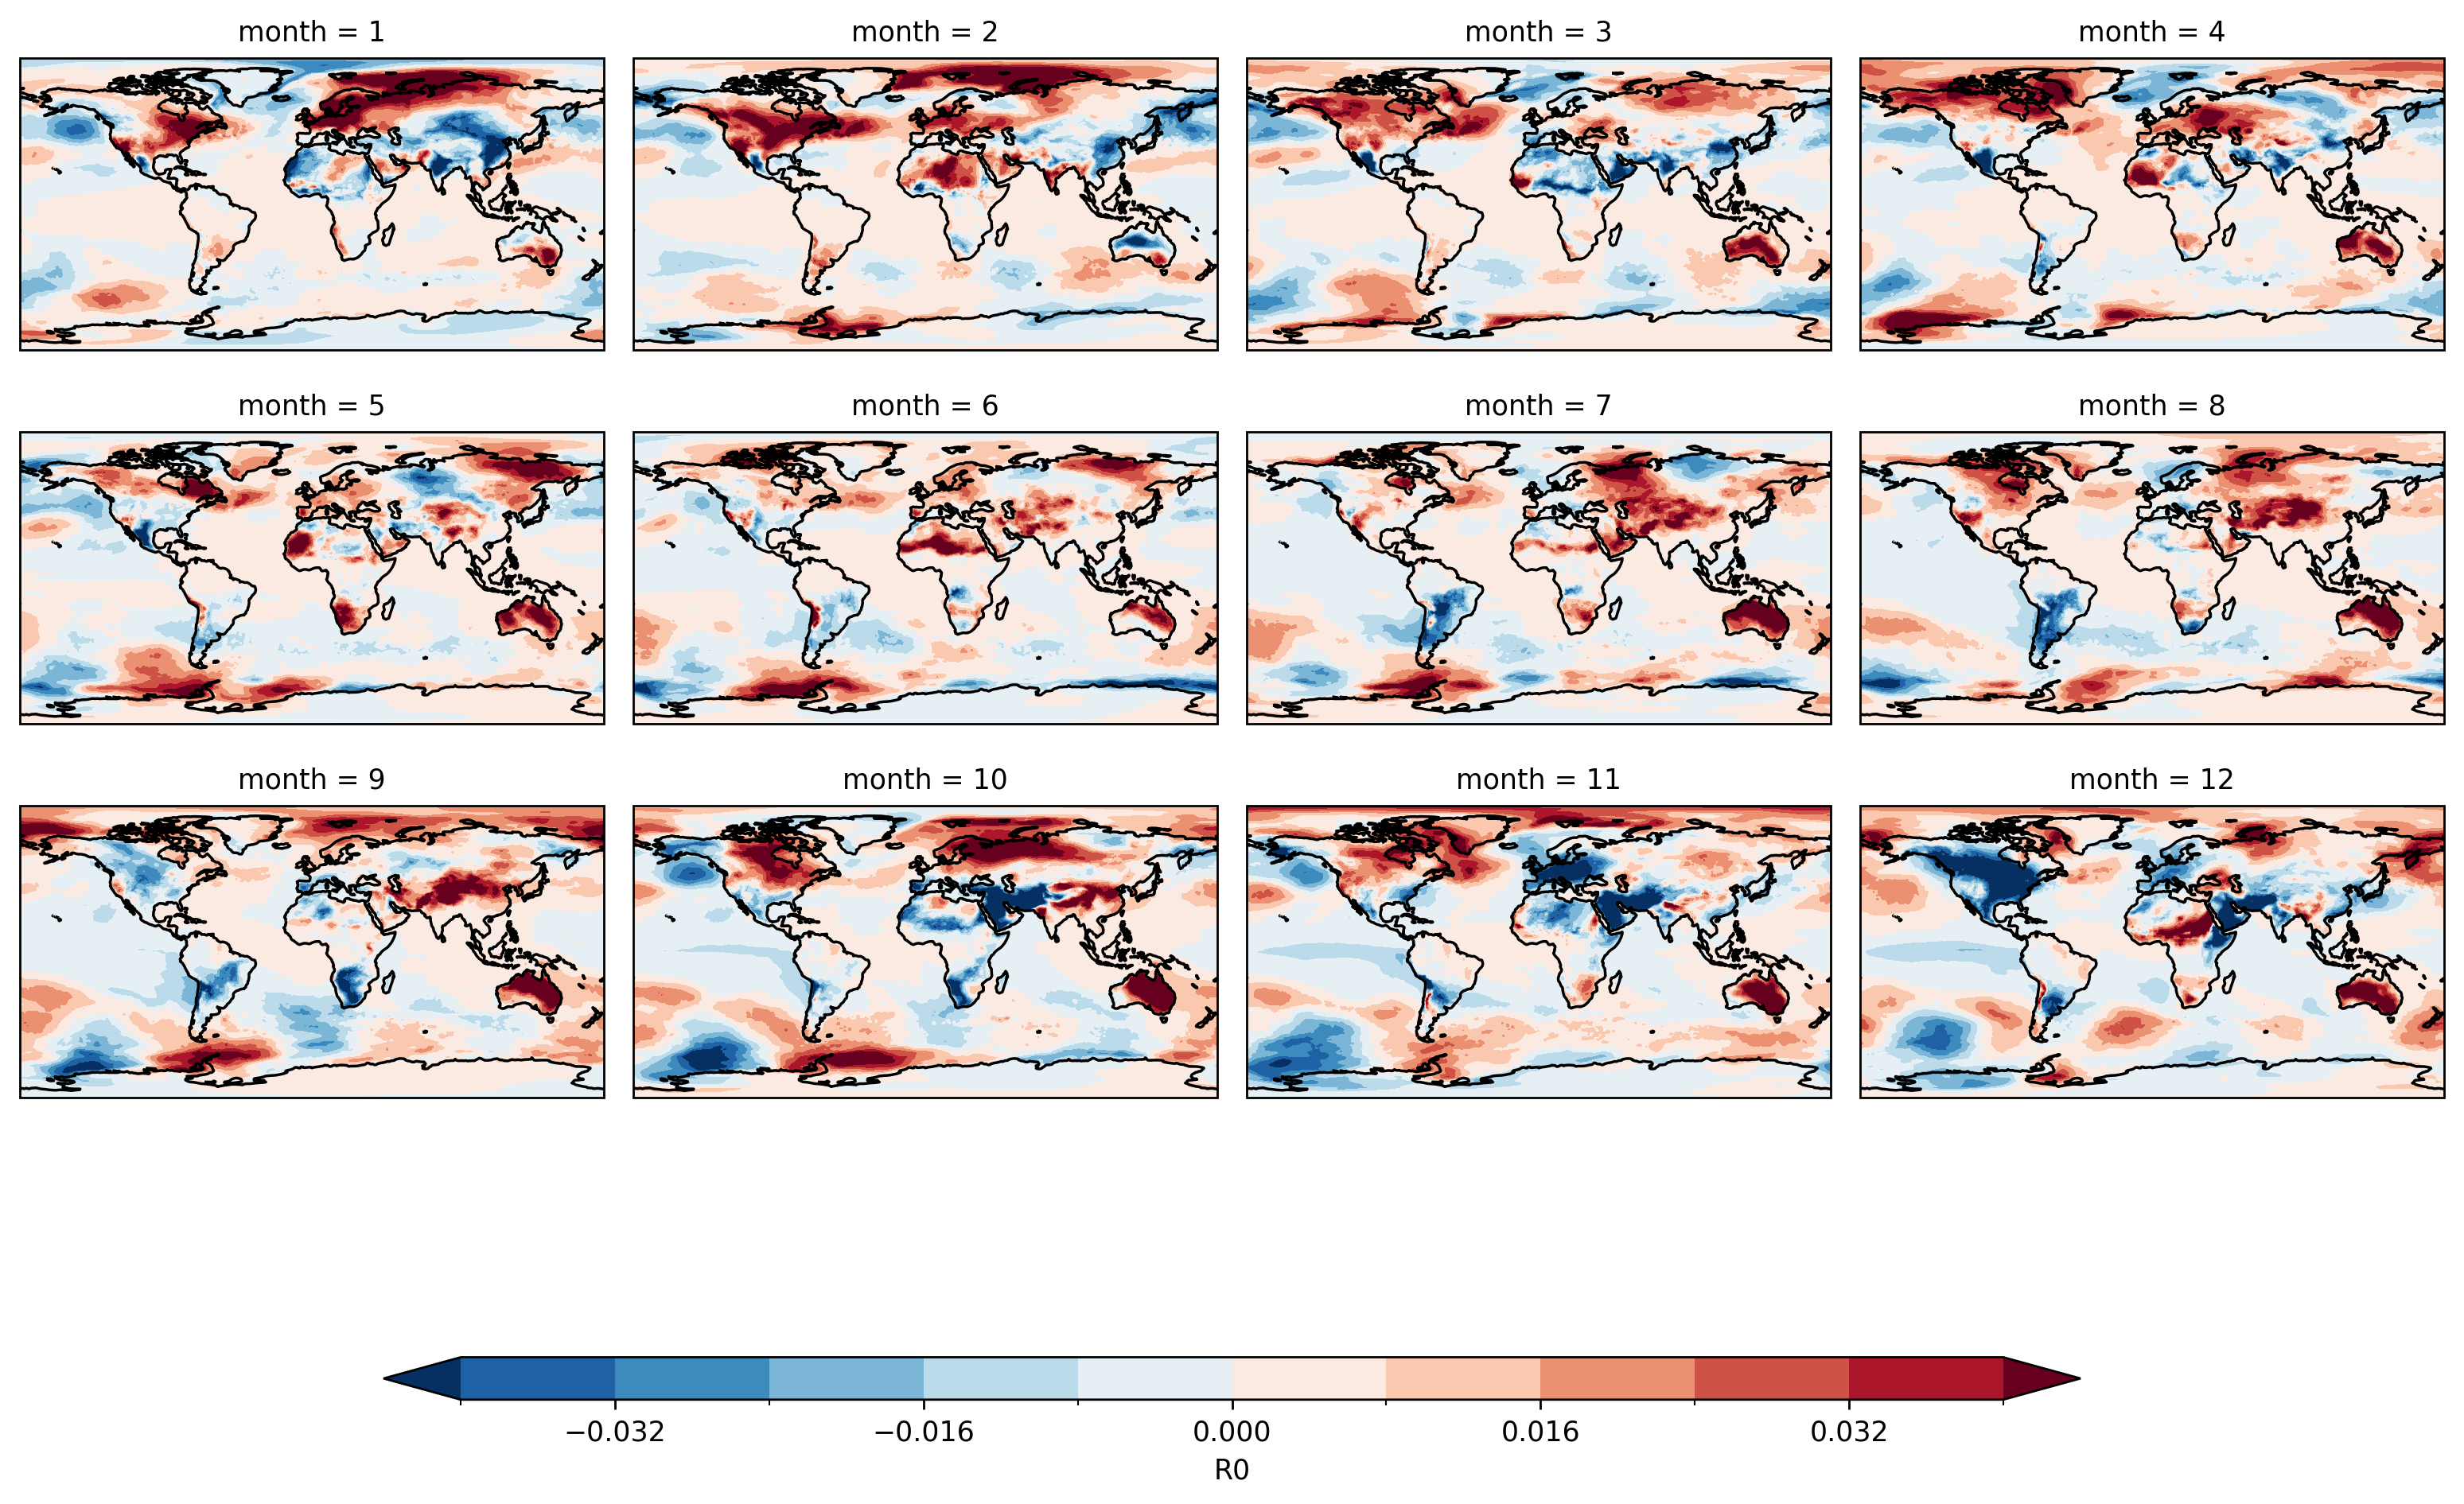

In [11]:
#Infected fraction
fg = (EN_mean-LN_mean).IT.plot.contourf(
    col="month", col_wrap=4,
    aspect=HKU1.dims['LON']/HKU1.dims['LAT']*.6, # sets aspect ratio
    transform=ccrs.PlateCarree(),  # remember to provide this!
    subplot_kws={
        "projection": ccrs.PlateCarree()
    },
    cmap='RdBu_r',extend='both', levels = 11, #vmin = -.0004, vmax = .0004,
    cbar_kwargs={"orientation": "horizontal", "aspect":40, "shrink": 0.7},
    robust=True,
)
fg.map(lambda: plt.gca().coastlines())

#Susceptible fraction
fg = (EN_mean-LN_mean).ST.plot.contourf(
    col="month", col_wrap=4,
    aspect=HKU1.dims['LON']/HKU1.dims['LAT']*.6, # sets aspect ratio
    transform=ccrs.PlateCarree(),  # remember to provide this!
    subplot_kws={
        "projection": ccrs.PlateCarree()
    },
    cmap='RdBu_r',extend='both', levels = 11, #vmin = -.0004, vmax = .0004,
    cbar_kwargs={"orientation": "horizontal", "aspect":40, "shrink": 0.7},
    robust=True,
)
fg.map(lambda: plt.gca().coastlines())

# R0
fg = (EN_mean-LN_mean).R0.plot.contourf(
    col="month", col_wrap=4,
    aspect=HKU1.dims['LON']/HKU1.dims['LAT']*.6, # sets aspect ratio
    transform=ccrs.PlateCarree(),  # remember to provide this!
    subplot_kws={
        "projection": ccrs.PlateCarree()
    },
    cmap='RdBu_r',extend='both', levels = 11, #vmin = -.0004, vmax = .0004,
    cbar_kwargs={"orientation": "horizontal", "aspect":40, "shrink": 0.7},
    robust=True,
)
fg.map(lambda: plt.gca().coastlines())